In [1]:
# can be used to install archtype analysis
import sys
!pip install py_pcha

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha
import os
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

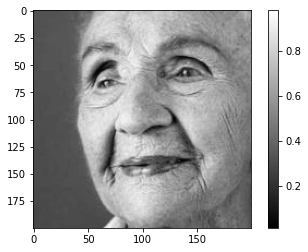

In [5]:
A=plt.imread('Faces/3.jpg')
A_gray=rgb2gray(A)
plt.imshow(A_gray,cmap='gray')
A_gray_norm=A_gray/255.0
plt.imshow(A_gray_norm,cmap='gray')
plt.colorbar();plt.show()

In [6]:
B=A_gray_norm.flatten()
C=np.hstack((1,B))
C

array([1.        , 0.32176549, 0.32176549, ..., 0.35668275, 0.34884039,
       0.34491922])

In [7]:
B

array([0.32176549, 0.32176549, 0.32176549, ..., 0.35668275, 0.34884039,
       0.34491922])

In [8]:
# load labels
labels=pd.read_csv('labels.csv',names=['age','gender','race']) # gender 0 male, 1 female (Races from 0 to 4)
labels.head()

,age,gender,race
0,100,0,0
1,100,0,0
2,100,1,0
3,100,1,0
4,100,1,0


In [9]:
#image shape = 200x200
data_paths = os.listdir('Faces')
n=len(data_paths)
p=1+200*200 # we add the label as the first element
X=np.zeros([n,p])
gender=np.zeros(n)
age=np.zeros(n)
print(f'number of observations: {n}, number of features: {p}')
# load images
for idx,el in enumerate(data_paths):
    img=plt.imread('Faces/'+el)
    img_gray=rgb2gray(img)
    img_gray_norm=img_gray/255.0
    flatten=img_gray_norm.flatten()
    # get the label
    race=labels.iloc[int(el[:-4]),2]
    gender[idx]=labels.iloc[int(el[:-4]),1]
    age[idx]=labels.iloc[int(el[:-4]),0]
    # hstack label (as the first element) and pixels
    features=np.hstack((race,flatten))
    X[idx]=features

number of observations: 23705, number of features: 40001


In [10]:
# data is already shuffled so we take 70 and 30%
traindata=X[:16594]
testdata=X[16594:]

In [157]:
Ntrain = 2000 # number of observations to use from train set
Ntest = 500 # number of observations to use from test set 

ytrain = traindata[0:Ntrain,0]
ytest = testdata[0:Ntest,0]
Xtrain = traindata[0:Ntrain,1:]
Xtest = testdata[0:Ntest,1:]
minX = np.min(np.min(Xtrain))
Xtrain=Xtrain-minX # Make sure X is non-negative (required for NMF)
Xtest=Xtest-minX;

k = 5 # number of nearest neighbours
lbda = .1 # L1 regularization used for SC and NSC

n_rows = 7 #for plotting
n_cols = 7 #for plotting

## PCA

In [140]:
X[0:100][:,0]

array([4., 3., 0., 3., 3., 1., 0., 2., 3., 1., 3., 2., 2., 0., 4., 1., 0.,
       0., 0., 3., 3., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 2., 2.,
       4., 0., 1., 0., 0., 2., 0., 0., 3., 0., 3., 1., 0., 0., 0., 0., 3.,
       2., 4., 0., 3., 4., 3., 0., 1., 2., 0., 1., 1., 1., 1., 0., 1., 3.,
       2., 0., 3., 2., 2., 1., 0., 2., 2., 3., 0., 0., 3., 2., 2., 1., 3.,
       0., 2., 3., 3., 3., 1., 1., 1., 1., 0., 1., 2., 2., 3., 3.])

In [163]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X[0:1000][:,1:])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
principalDf['Race']=X[0:1000][:,0].astype('int')
principalDf['Gender']=gender[0:1000].astype('int');principalDf['Age']=age[0:1000].astype('int')
principalDf

,PC1,PC2,Race,Gender,Age
0,21.931559,17.513510,4,0,29
1,-11.780854,7.314087,3,1,36
2,-7.001035,-16.763170,0,0,10
3,23.622538,4.442411,3,0,26
4,-21.549627,34.693762,3,1,35
...,...,...,...,...,...
995,-33.085039,4.687556,1,1,26
996,-32.364055,-1.604574,0,1,34
997,-38.996273,-9.836204,2,1,35
998,-21.793829,-16.411015,3,1,16


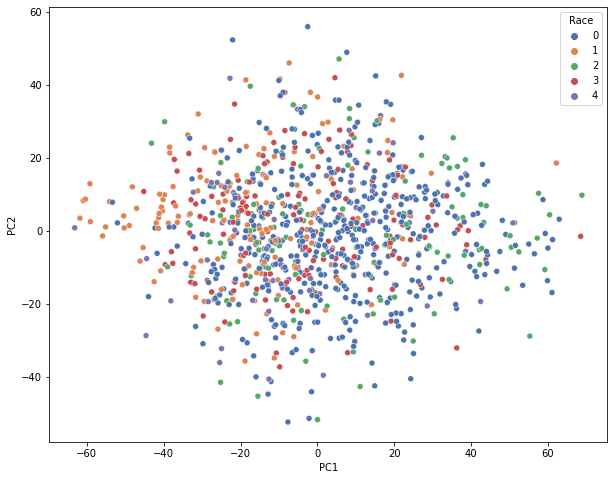

In [167]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.scatterplot(principalDf.PC1,principalDf.PC2,hue=principalDf.Race,palette="deep")
plt.show()

In [120]:
left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (200, 200)
# Function for plotting images
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    start_index = random.randint(0, n)
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 499)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

## Dimension Reduction

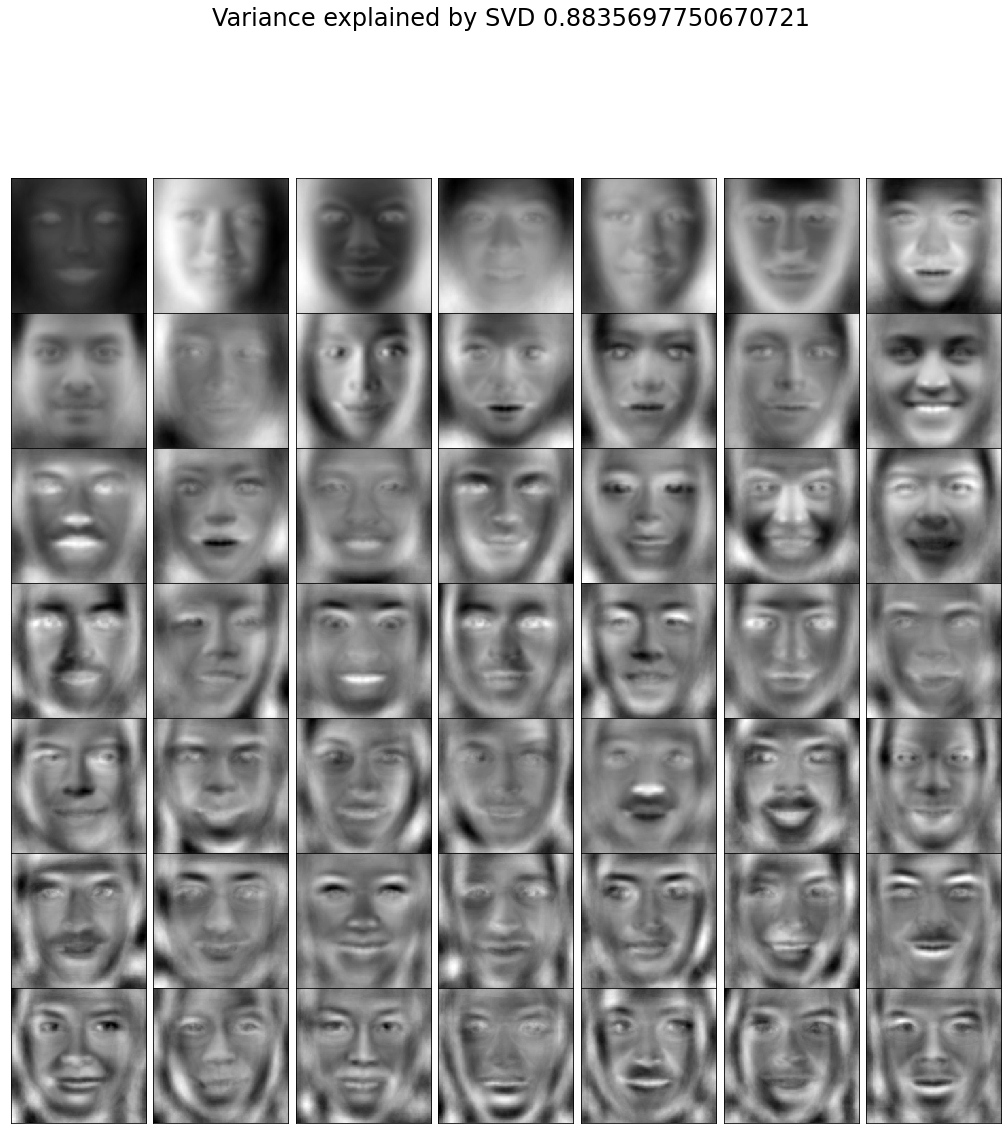

In [180]:
n_components = 49 # num components

SST = np.sum(np.sum(Xtrain**2))

model = decomposition.PCA(n_components=n_components)
# Fit svd with centered data
Xtrain = Xtrain - np.mean(Xtrain)
Xtest = Xtest - np.mean(Xtrain)
model.fit(Xtrain)
components = model.components_
plot_components(f'Variance explained by SVD {model.explained_variance_ratio_.sum()}', components)

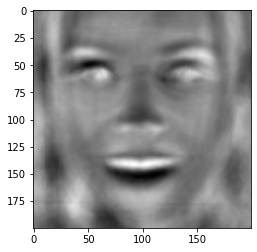

In [207]:
n_components = 49 # num components

SST = np.sum(np.sum(Xtrain**2))

model = decomposition.PCA(n_components=n_components)
# Fit svd with centered data
Xtrain = Xtrain - np.mean(Xtrain)
Xtest = Xtest - np.mean(Xtrain)
model.fit(Xtrain)
components = model.components_

plt.imshow(components[n_components-1].reshape([200,200]),cmap='gray');plt.show()

## Clustering Algorithm

In [208]:
model =  KMeans(n_clusters=n_components)
# Fit model with data
model.fit(Xtrain)
components = model.cluster_centers_
enc = preprocessing.OneHotEncoder(sparse=False)
cluster_affiliation = enc.fit_transform(np.expand_dims(model.labels_,axis=1))
X_hat = cluster_affiliation @ components
L = 0.5*np.linalg.norm(Xtrain-X_hat)**2

knn.fit(cluster_affiliation,ytrain)
cluster_affiliation_test = enc.transform(np.expand_dims(model.predict(Xtest),axis=1))
acc = knn.score(cluster_affiliation_test,ytest)
X_test_hat = cluster_affiliation_test @ components

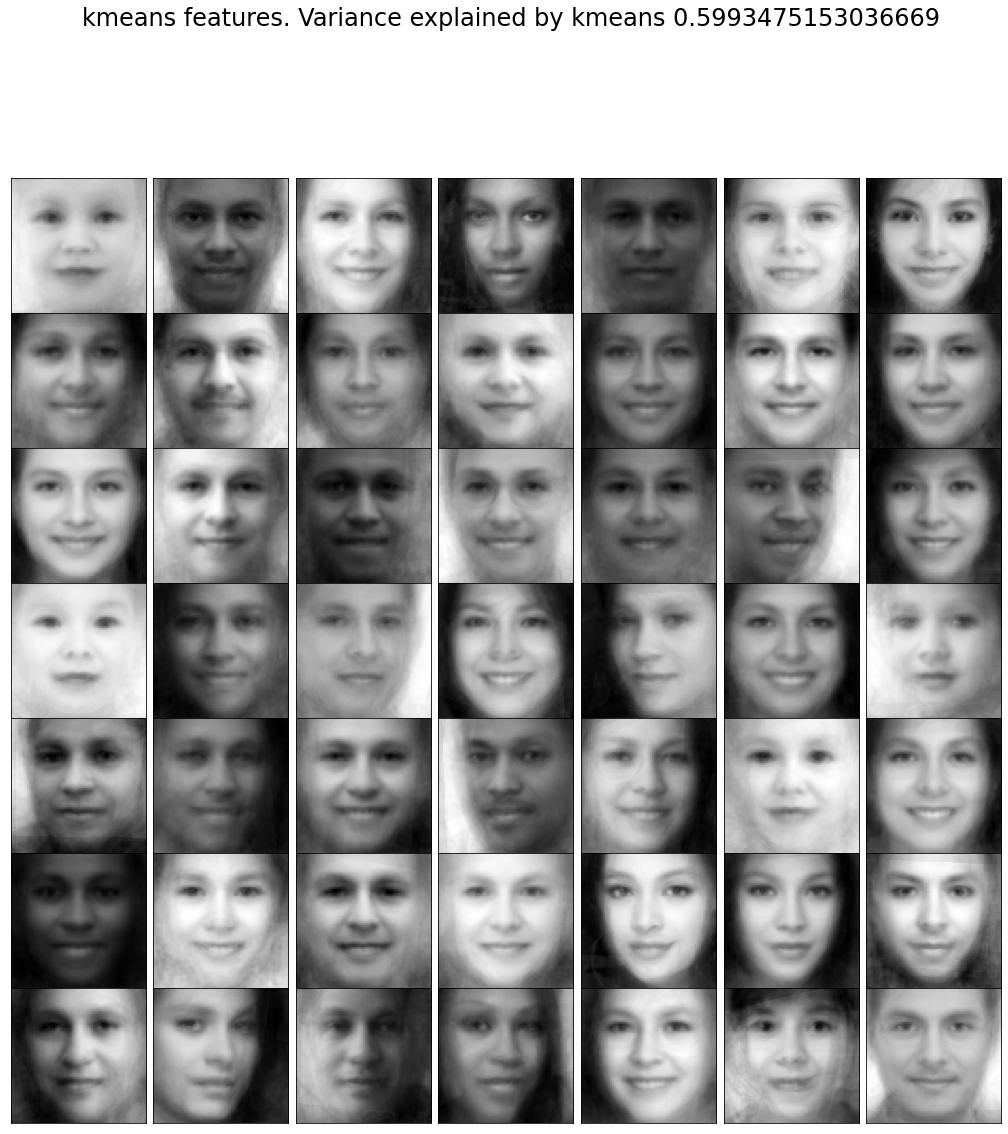

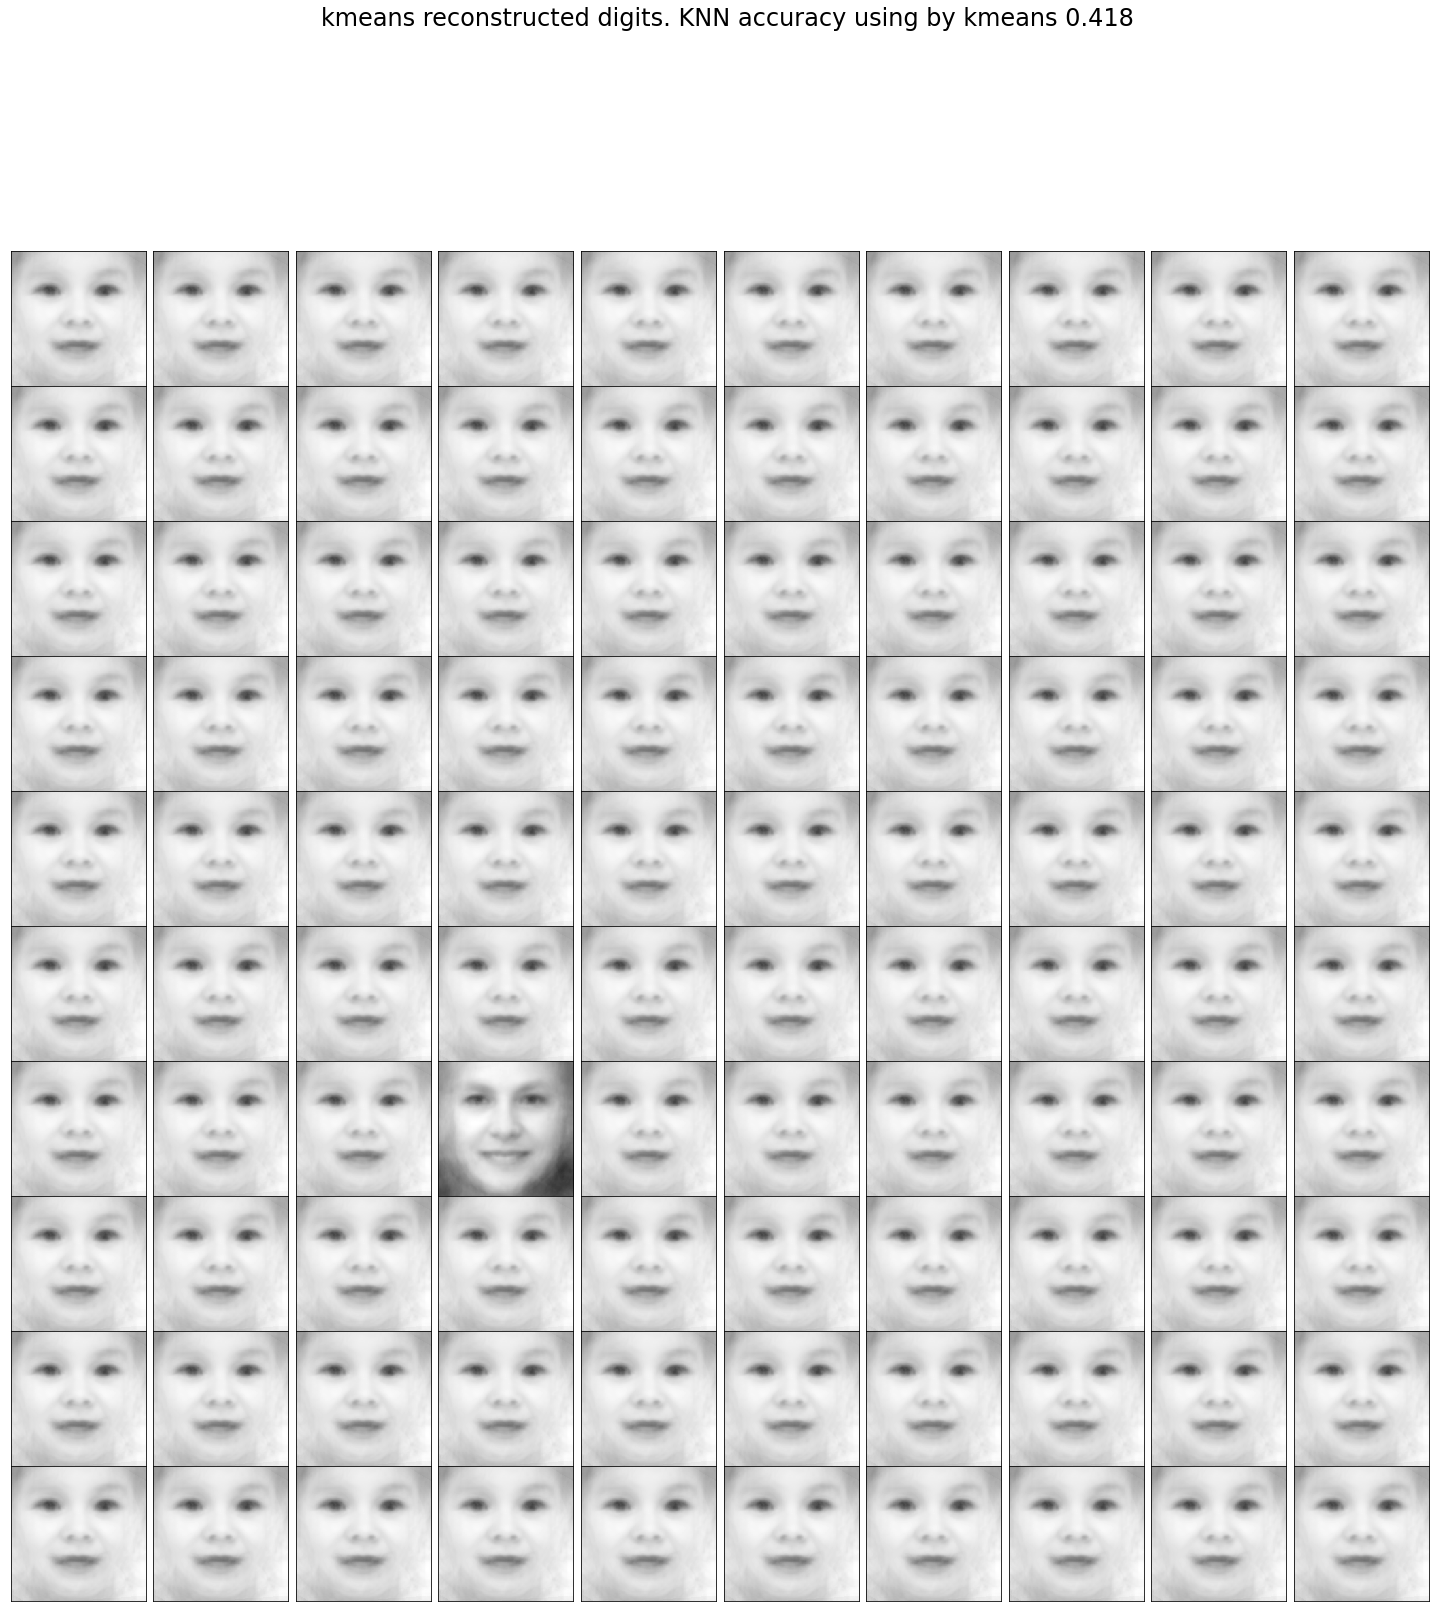

In [209]:
plot_components(f'{method} features. Variance explained by {method} {1-2*L/SST}', components)
plot_recons(X_test_hat, f'{method} reconstructed digits. KNN accuracy using by {method} {acc}')

## Self-Organizing Map

In [210]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)
    
# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

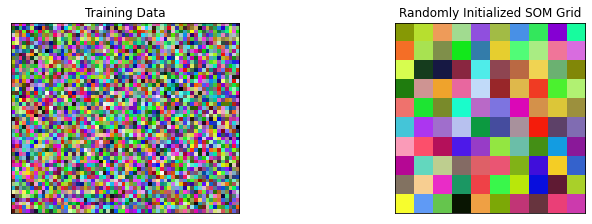

In [211]:
# Dimensions of the SOM grid
m = 10
n = 10
# Number of training examples
n_x = 3000
rand = np.random.RandomState(0)
# Initialize the training data
train_data = rand.randint(0, 255, (n_x, 3))
# Initialize the SOM randomly
SOM = rand.randint(0, 255, (m, n, 3)).astype(float)
# Display both the training matrix and the SOM grid
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(train_data.reshape(50, 60, 3))
ax[0].title.set_text('Training Data')
ax[1].imshow(SOM.astype(int))
ax[1].title.set_text('Randomly Initialized SOM Grid')

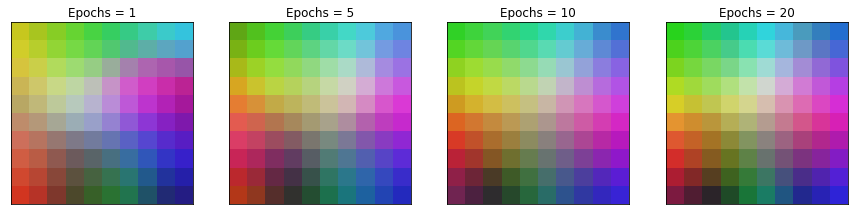

In [212]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
for epochs, i in zip([1, 4, 5, 10], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, train_data, epochs=epochs)
    ax[i].imshow(SOM.astype(int))
    ax[i].title.set_text('Epochs = ' + str(total_epochs))

In [199]:
ytrain.shape

(2000,)

In [198]:
Xtrain.shape

(2000, 40000)

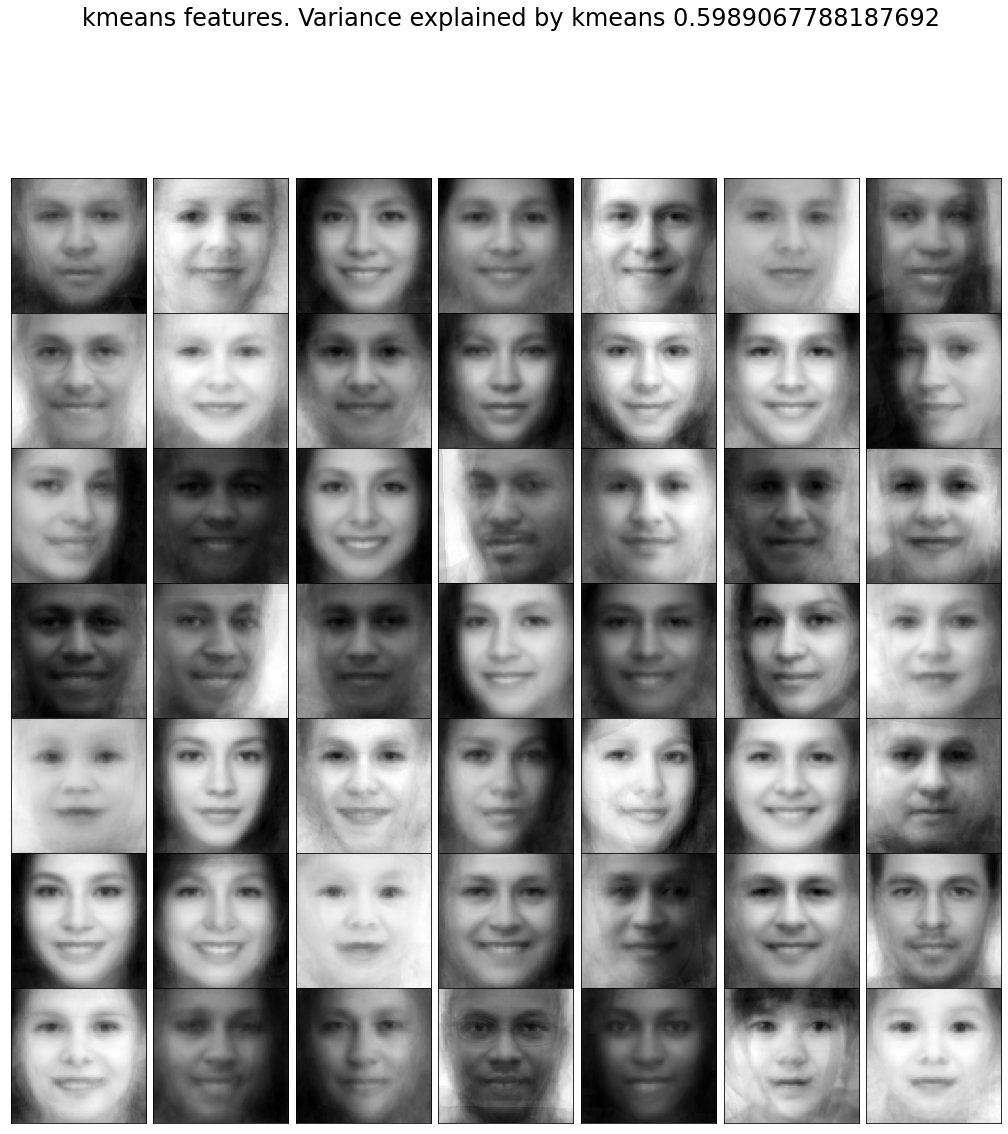

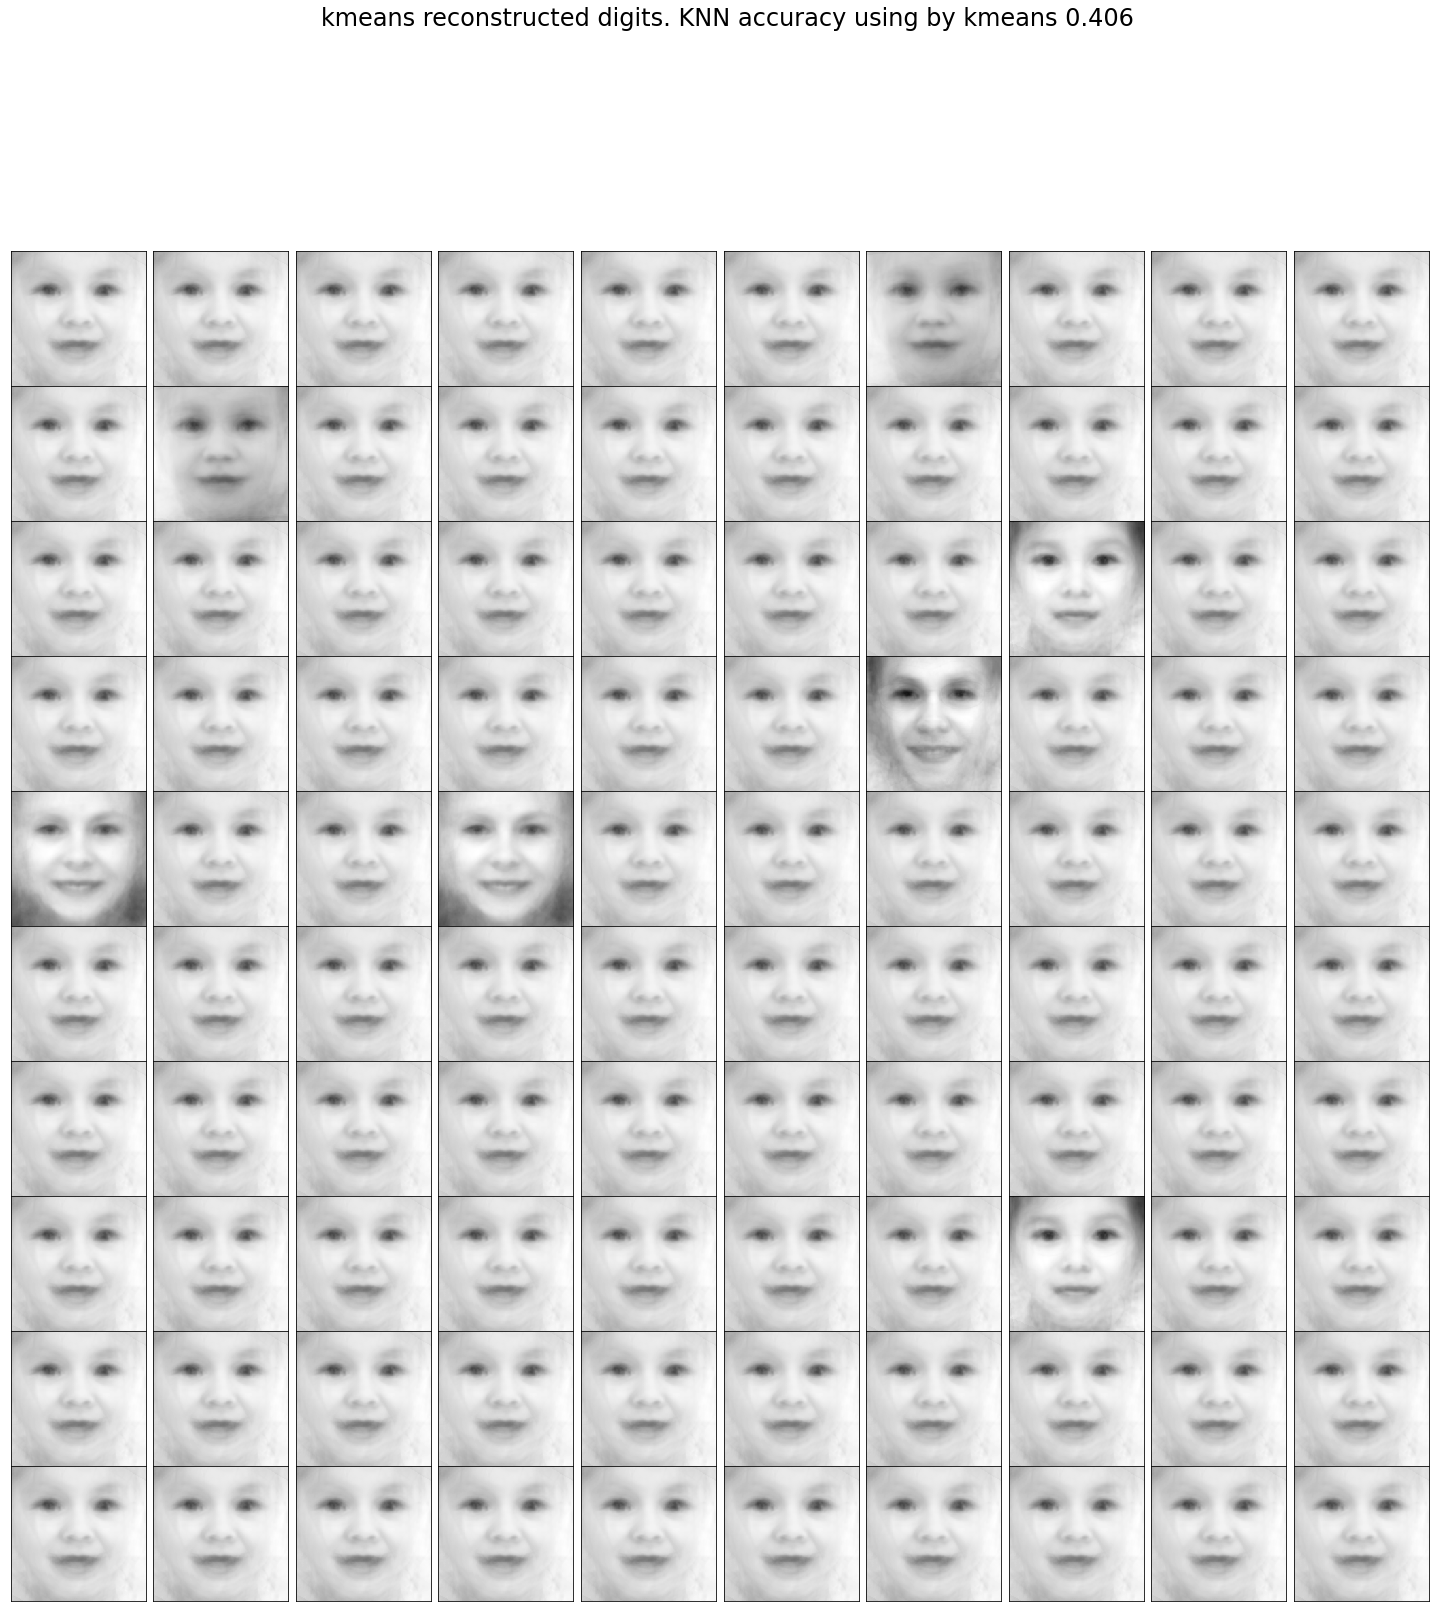

In [125]:
methods = ['SVD','NMF', 'AA', 'SC', 'kmeans']
method= methods[4]

n_components = 49 # num components
knn = KNeighborsClassifier(n_neighbors=k)
if method == 'SVD':
    model = decomposition.PCA(n_components=n_components)
    X_train_transformed = model.fit_transform(Xtrain)
    X_hat = X_train_transformed.dot(model.components_) + model.mean_
    L = 0.5*np.linalg.norm(Xtrain-X_hat)**2
    components = model.components_
    
    knn.fit(X_train_transformed,ytrain)
    acc = knn.score(model.transform(Xtest),ytest)
    X_test_hat = model.transform(Xtest).dot(model.components_) + model.mean_
elif method == 'NMF':
    # Create model init method is set to random
    model = decomposition.NMF(n_components=n_components, init='random', random_state=0)
    X_train_transformed = model.fit_transform(Xtrain)
    L = 0.5*model.reconstruction_err_**2
    components = model.components_
    
    knn.fit(X_train_transformed,ytrain)
    acc = knn.score(model.transform(Xtest),ytest)
    X_test_hat = model.transform(Xtest).dot(model.components_)
elif method == 'AA':
    # Does not require that you center data
    XC, S, C, SSE, varexpl = py_pcha.PCHA(Xtrain.T, noc=n_components, delta=0.1)
    X_hat = Xtrain.T @ C @ S
    L = 0.5*np.linalg.norm(Xtrain.T-X_hat)**2
    components = XC.T
    
    knn.fit(S.T,ytrain)
    Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S
    acc = knn.score(Xtest_transform.T,ytest)
    X_test_hat = (XC @ Xtest_transform).T
    
elif method == 'SC':
    model = decomposition.DictionaryLearning(n_components=n_components, alpha=lbda, transform_alpha=lbda, max_iter=100, transform_max_iter=100, fit_algorithm='cd', transform_algorithm='lasso_cd')
    X_train_transformed = model.fit_transform(Xtrain)
    X_hat = X_train_transformed @ model.components_
    L = 0.5*np.linalg.norm(Xtrain-X_hat)**2
    components = model.components_
    
    knn.fit(X_train_transformed,ytrain)
    acc = knn.score(model.transform(Xtest),ytest)
    X_test_hat = model.transform(Xtest) @ model.components_
elif method == 'kmeans':
    model =  KMeans(n_clusters=n_components)
    # Fit model with data
    model.fit(Xtrain)
    components = model.cluster_centers_
    enc = preprocessing.OneHotEncoder(sparse=False)
    cluster_affiliation = enc.fit_transform(np.expand_dims(model.labels_,axis=1))
    X_hat = cluster_affiliation @ components
    L = 0.5*np.linalg.norm(Xtrain-X_hat)**2
    
    knn.fit(cluster_affiliation,ytrain)
    cluster_affiliation_test = enc.transform(np.expand_dims(model.predict(Xtest),axis=1))
    acc = knn.score(cluster_affiliation_test,ytest)
    X_test_hat = cluster_affiliation_test @ components
    
plot_components(f'{method} features. Variance explained by {method} {1-2*L/SST}', components)
plot_recons(X_test_hat, f'{method} reconstructed digits. KNN accuracy using by {method} {acc}')